https://habr.com/ru/articles/331500/

Manifold learning

In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Создание датасета
x1 = np.linspace(-2.2, 2.2, 1000)
fx = np.sin(x1)
dots = np.vstack([x1, fx]).T
noise = 0.06 * np.random.randn(*dots.shape)
dots += noise

# Цветные точки для отдельной визуализации позже
from itertools import cycle
size = 25
colors = ["r", "g", "c", "y", "m"]
idxs = range(0, x1.shape[0], x1.shape[0]//size)
vx1 = x1[idxs]
vdots = dots[idxs]

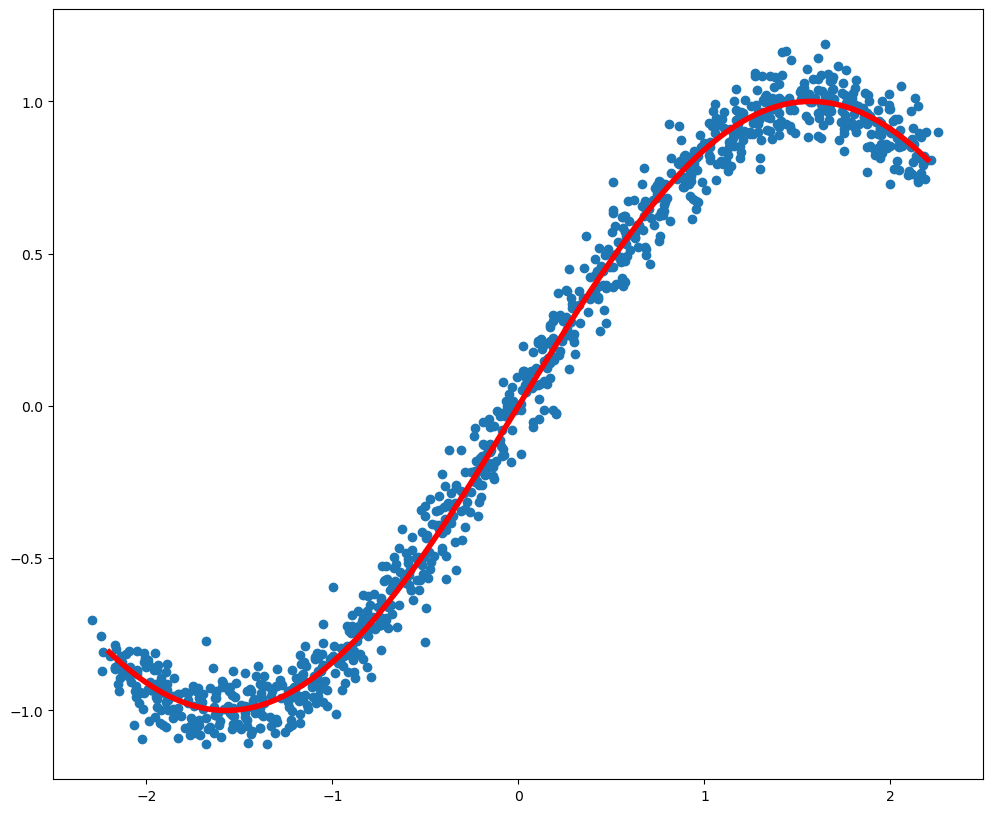

In [4]:
# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1])
plt.plot(x1, fx,  color="red", linewidth=4)
plt.grid(False)

Линейный сжимающий автоэнкодер


In [5]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

def linear_ae():
    input_dots = Input((2,))
    code = Dense(1, activation='linear')(input_dots)
    out  = Dense(2, activation='linear')(code)

    ae = Model(input_dots, out)
    return ae

ae = linear_ae()
ae.compile(Adam(0.01), 'mse')

ae.fit(dots, dots, epochs=15, batch_size=30, verbose=0)

In [7]:
# Применение линейного автоэнкодера
pdots = ae.predict(dots, batch_size=30)
vpdots = pdots[idxs]

# Применение PCA
from sklearn.decomposition import PCA
pca = PCA(1)
pdots_pca = pca.inverse_transform(pca.fit_transform(dots))

34/34 [==============================] - 0s 684us/step


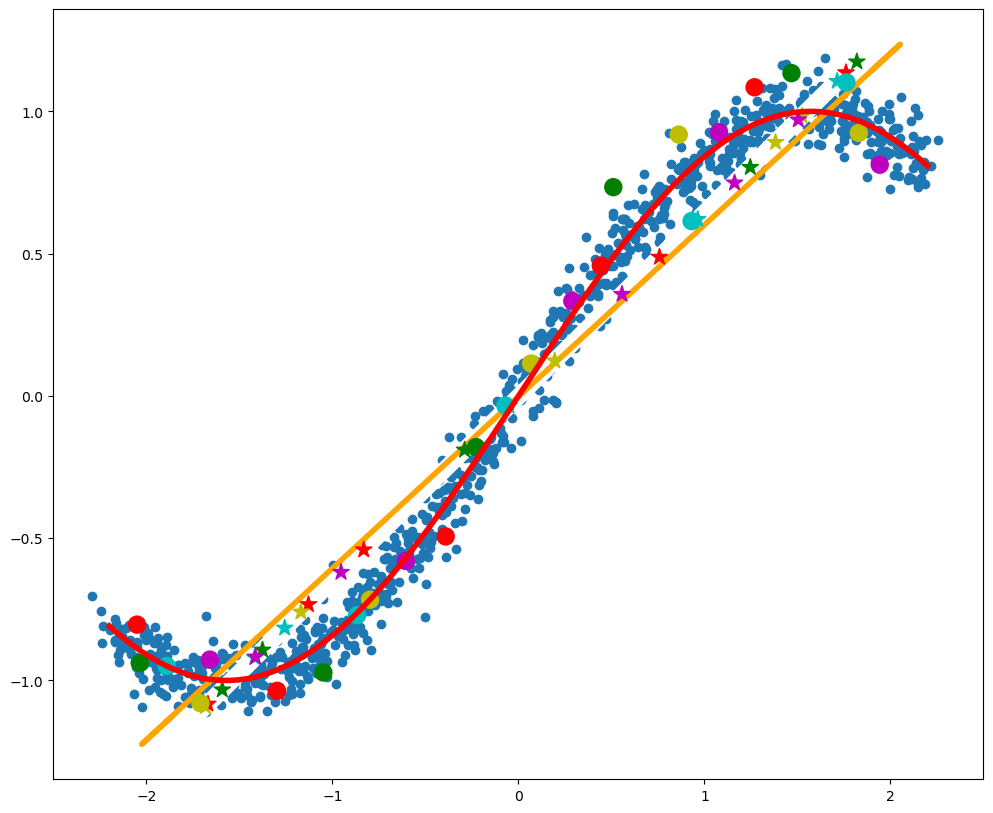

In [8]:
# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots[:,0], pdots[:,1], color='white', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.scatter(vpdots[:,0], vpdots[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)

Глубокий автоэнкодер

In [9]:
def deep_ae():
    input_dots = Input((2,))
    x = Dense(64, activation='elu')(input_dots)
    x = Dense(64, activation='elu')(x)
    code = Dense(1, activation='linear')(x)
    x = Dense(64, activation='elu')(code)
    x = Dense(64, activation='elu')(x)
    out = Dense(2, activation='linear')(x)

    ae = Model(input_dots, out)
    return ae

dae = deep_ae()
dae.compile(Adam(0.003), 'mse')

dae.fit(dots, dots, epochs=200, batch_size=30, verbose=0)
pdots_d = dae.predict(dots, batch_size=30)
vpdots_d = pdots_d[idxs]


34/34 [==============================] - 0s 424us/step


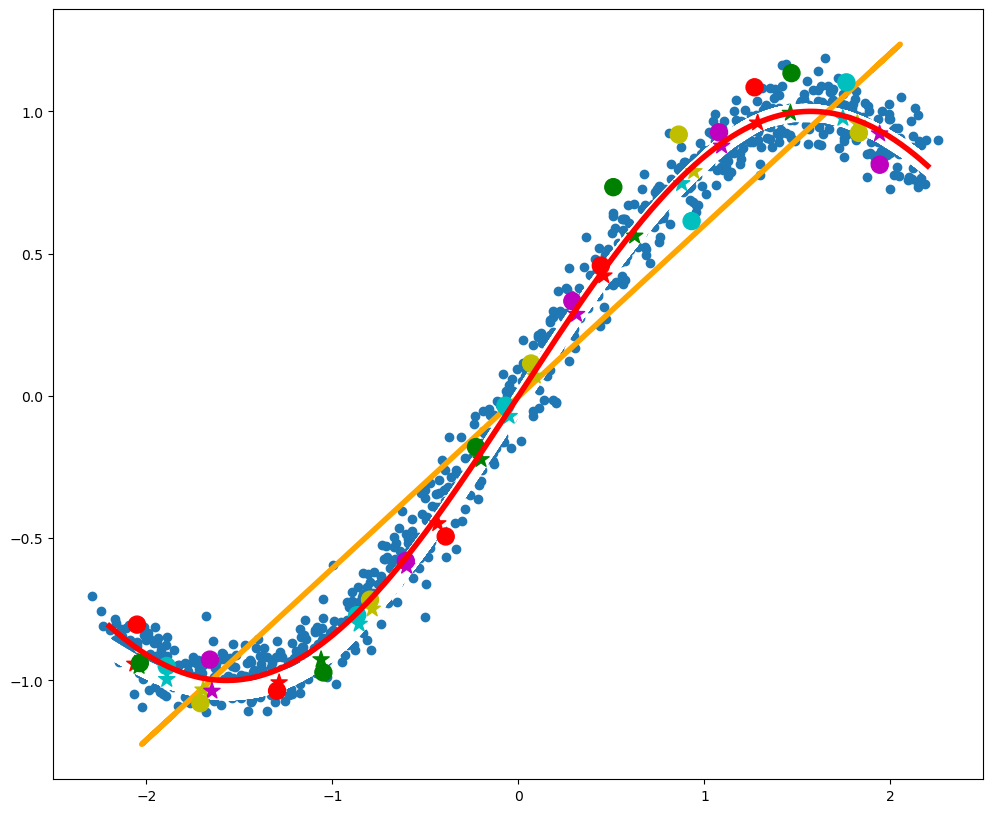

In [10]:
# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots_d[:,0], pdots_d[:,1], color='white', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.scatter(vpdots_d[:,0], vpdots_d[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)

In [12]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

# Сверточный автоэнкодер
def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
c_autoencoder.fit(x_train, x_train,
                epochs=3,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

# Гомотопия по прямой между объектами или между кодами
def plot_homotopy(frm, to, n=10, decoder=None):
    z = np.zeros(([n] + list(frm.shape)))
    for i, t in enumerate(np.linspace(0., 1., n)):
        z[i] = frm * (1-t) + to * t
    if decoder:
        plot_digits(decoder.predict(z, batch_size=n))
    else:
        plot_digits(z)


Epoch 1/3
235/235 [==============================] - 262s 1s/step - loss: 0.1864 - val_loss: 0.1045
Epoch 2/3
235/235 [==============================] - 284s 1s/step - loss: 0.0984 - val_loss: 0.0918
Epoch 3/3
235/235 [==============================] - 292s 1s/step - loss: 0.0899 - val_loss: 0.0870


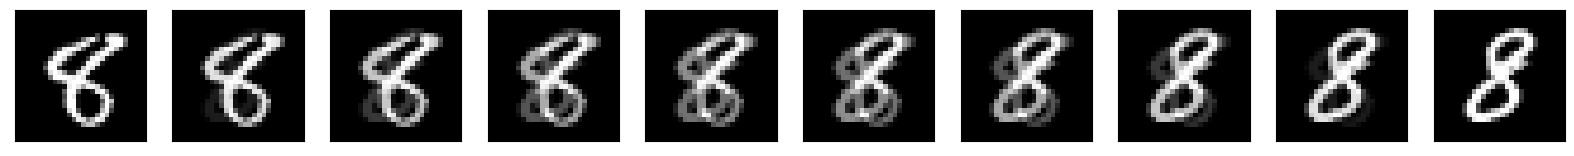

In [13]:
# Гомотопия между первыми двумя восьмерками
frm, to = x_test[y_test == 8][1:3]
plot_homotopy(frm, to)

1/1 [==============================] - 0s 41ms/step


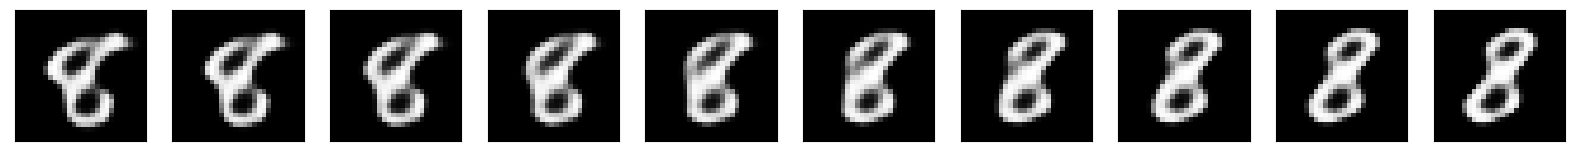

In [14]:
codes = c_encoder.predict(x_test[y_test == 8][1:3])
plot_homotopy(codes[0], codes[1], n=10, decoder=c_decoder)

Скрытые переменные

In [37]:
from keras.layers import Flatten, Reshape
from keras.regularizers import L1L2

def create_deep_sparse_ae(lambda_l1):
    # Размерность кодированного представления
    encoding_dim = 16

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*4, activation='relu')(flat_img)
    x = Dense(encoding_dim*3, activation='relu')(x)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1, 0))(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    x = Dense(encoding_dim*4, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = create_deep_sparse_ae(0.)
autoencoder.compile(optimizer=Adam(0.0003), loss='binary_crossentropy')


In [38]:
autoencoder.fit(x_train, x_train,
                      epochs=10,
                      batch_size=64,
                      shuffle=True,
                      validation_data=(x_test, x_test))


Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2479 - val_loss: 0.1812
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1691 - val_loss: 0.1587
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1542 - val_loss: 0.1487
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1461 - val_loss: 0.1409
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1398 - val_loss: 0.1361
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1355 - val_loss: 0.1330
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1326 - val_loss: 0.1306
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1303 - val_loss: 0.1281
Epoch 9/10
938/938 [==============================] - 2s 2ms/step - loss: 0.1285 - val_loss: 0.1265
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1269 - val_loss: 0.1248

1/1 [==============================] - 0s 78ms/step


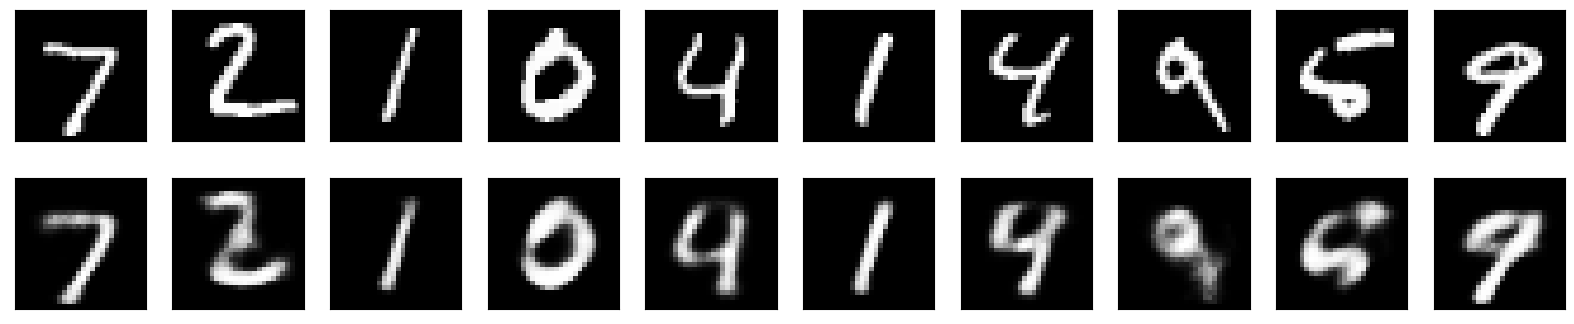

In [39]:
n = 10
imgs = x_test[:n]
decoded_imgs = autoencoder.predict(imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

313/313 [==============================] - 0s 637us/step


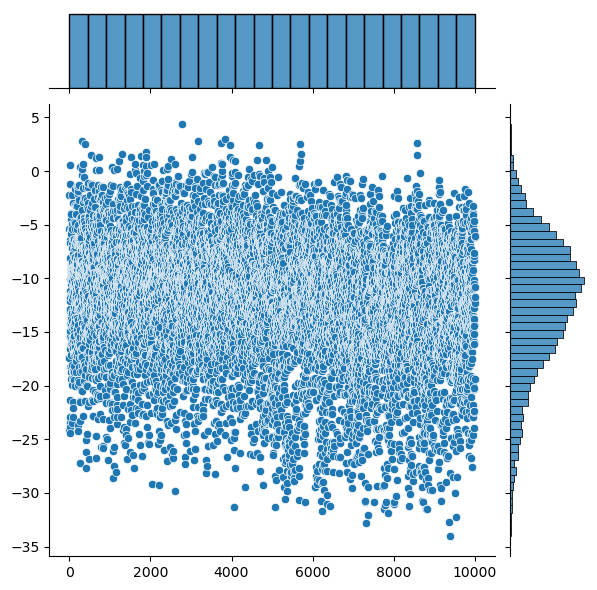

In [41]:
codes = encoder.predict(x_test)
sns.jointplot(codes[:,3])
# sns.jointplot(codes[:,1], codes[:,3])

In [42]:
s_encoder, s_decoder, s_autoencoder = create_deep_sparse_ae(0.00001)
s_autoencoder.compile(optimizer=Adam(0.0003), loss='binary_crossentropy')

In [44]:
s_autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, 
                          validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1576 - val_loss: 0.1541
Epoch 2/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1533 - val_loss: 0.1495
Epoch 3/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1491 - val_loss: 0.1460
Epoch 4/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1456 - val_loss: 0.1428
Epoch 5/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1430 - val_loss: 0.1406
Epoch 6/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1410 - val_loss: 0.1386
Epoch 7/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1391 - val_loss: 0.1366
Epoch 8/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1371 - val_loss: 0.1346
Epoch 9/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1350 - val_loss: 0.1327
Epoch 10/10
235/235 [==============================] - 1s 4ms/step - loss: 0.1334 - val_loss: 0.1312

1/1 [==============================] - 0s 54ms/step


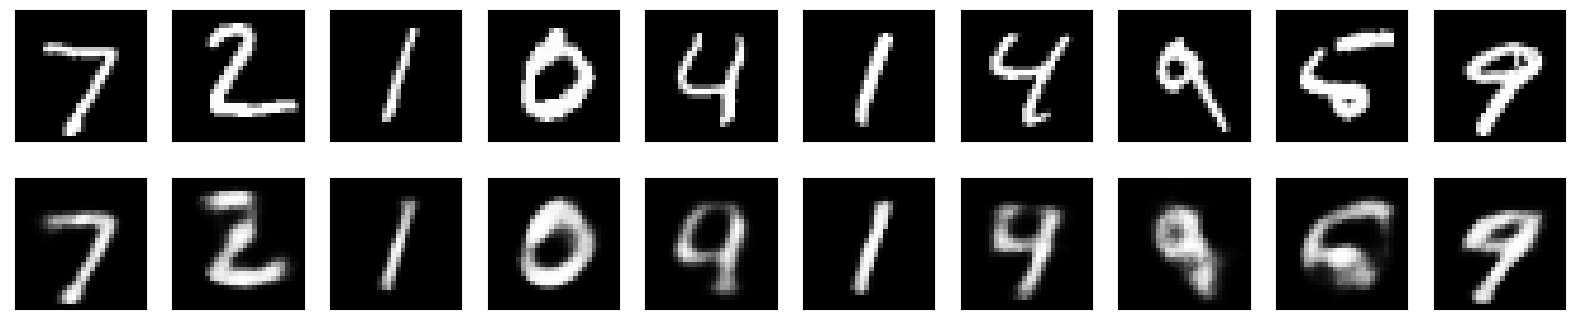

In [45]:
imgs = x_test[:n]
decoded_imgs = s_autoencoder.predict(imgs, batch_size=n)
plot_digits(imgs, decoded_imgs)

313/313 [==============================] - 0s 635us/step


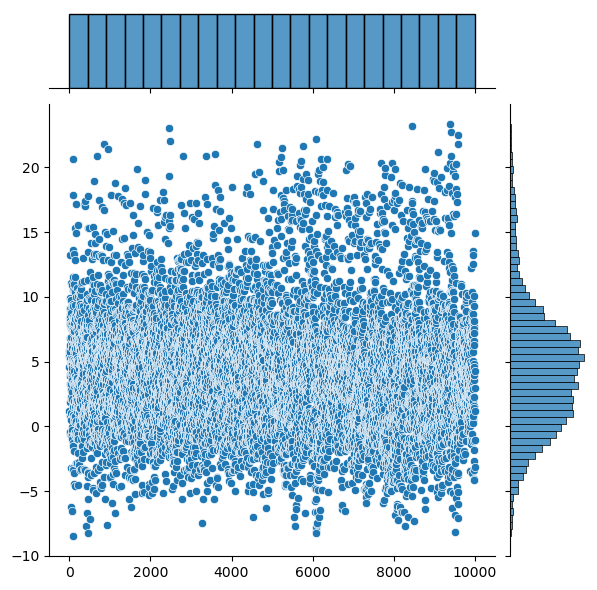

In [48]:
codes = s_encoder.predict(x_test)
sns.jointplot(codes[:,1])
# snt.jointplot(codes[:,1], codes[:,3])